In [1]:
# Imports
import pickle
import string
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf

In [2]:
dataset = xr.open_dataarray('/glade/work/molina/DATA/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

print(dataarray.shape)

(30660, 9211)


In [3]:
# Import the regime labels
WR_labels_df = pd.read_csv('df_labels_nocorrfilt_ERA5.csv')
WR_labels_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
WR_labels_df['date'] = pd.to_datetime(WR_labels_df['date'], format='%Y-%m-%d')
WR_labels_dict = {0: 'Polar High', 1: 'Pacific Trough', 2: 'Pacific Ridge', 
                  3: 'Alaskan Ridge', 4: 'Atlantic Ridge', 5: 'No WR'}
WR_labels = np.array(WR_labels_df['WR'])

# Set up our lats and lons
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

# get the closest and furthest distance days
wr = 1
closest = min(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
furthest = max(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
cidx = WR_labels_df[WR_labels_df['distances'] == closest].index[0]
fidx = WR_labels_df[WR_labels_df['distances'] == furthest].index[0]
cdata = dataarray[cidx].reshape((lons.shape[0], lats.shape[1]))
fdata = dataarray[fidx].reshape((lons.shape[0], lats.shape[1]))

# get the regime mean
wr_idxs = np.array(WR_labels == wr).nonzero()[0]
regime_mean = np.mean(dataarray[wr_idxs], axis=0).reshape((lons.shape[0], lats.shape[1]))

In [4]:
abcd = list(string.ascii_lowercase)
fontsize_most_things = 12
mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

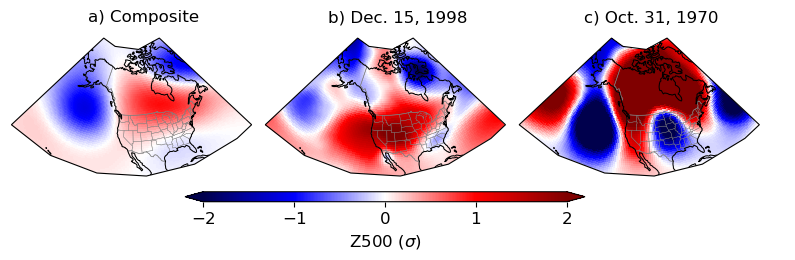

In [5]:
fig, axes = plt.subplots(
    1, 3, 
    figsize=(10, 4), 
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(
        central_longitude=-115,
        central_latitude=50,
        standard_parallels=(30, 70)
    )}
)
extent = [-180, -50, 20, 80]

# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]
# ################# PLOT Mean ######################

pm = axes[0].pcolormesh(
    lons, lats, regime_mean, transform=ccrs.PlateCarree(), 
    vmin=mini, vmax=maxi, cmap='seismic'
)
axes[0].set_title(
    f'{abcd[0]}) Composite', 
    fontsize=fontsize_most_things,
    loc='center'
)
axes[0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axes[0].margins(x=0, y=0)
axes[0].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)
axes[0].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  

# Set the boundary of the plot
rect = mpath.Path(verts)
axes[0].set_boundary(rect, transform=ccrs.PlateCarree())

# ################# PLOT Ex. 1 ######################

pm = axes[1].pcolormesh(
    lons, lats, cdata,
    transform=ccrs.PlateCarree(),
    vmin=mini, vmax=maxi, cmap='seismic'
)
axes[1].set_title(
    f'{abcd[1]}) Dec. 15, 1998', 
    fontsize=fontsize_most_things, loc='center'
)
axes[1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axes[1].margins(x=0, y=0)
axes[1].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)
axes[1].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)

# Set the boundary of the plot
rect = mpath.Path(verts)
axes[1].set_boundary(rect, transform=ccrs.PlateCarree())

# ################# PLOT Ex. 2 ######################

pm = axes[2].pcolormesh(
    lons, lats, fdata,
    transform=ccrs.PlateCarree(),
    vmin=mini, vmax=maxi, cmap='seismic'
)
axes[2].set_title(
    f'{abcd[2]}) Oct. 31, 1970', 
    fontsize=fontsize_most_things,
    loc='center'
)
axes[2].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axes[2].margins(x=0, y=0)
axes[2].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)
axes[2].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)

rect = mpath.Path(verts)
axes[2].set_boundary(rect, transform=ccrs.PlateCarree())

# ################# CBAR ######################

cbar_ax = fig.add_axes([0.3, 0.25, 0.4, 0.025])
ticks_1 = [-2, -1, 0, 1, 2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label(r'Z500 ($\sigma$)', 
               fontsize=fontsize_most_things)

plt.subplots_adjust(wspace=-0.05, hspace=0.0)
plt.savefig('PT_Diversity_v20250605.pdf', transparent=True, bbox_inches='tight')
plt.show()